In [1]:
from chembl_miner import *
import pandas as pd
set_verbosity(2)

In [2]:
# Previamente, verifiquei no website da ChEMBL que este alvo possui
# bom volume de dados para este tipo de atividade
activity_df = get_activity_data(
        target_chembl_id="CHEMBL366",
        activity_type="MIC",
        )

# Palavras-chave de interesse para exclusão determinada usando max_entries maior.
id_list = review_assays(
        activity_df=activity_df,
        max_entries=10,
        assay_keywords=["agar","cotreated","presence","resistant","clinical"],
        exclude_keywords=True,
        inner_join=False
        )
        
# Preprocessamento padrão - garante ausência de valores inválidos,
# calcula características moleculares básicas, padroniza e transforma
# os dados.
activity_df = preprocess_data(
        activity_df=activity_df,
        convert_units=True,
        assay_ids=id_list)

#para fins de exemplo, reduzi o tamanho dos dados.
activity_df = activity_df.iloc[0:1000,:]


# Cálculo dos descritores. Por padrão, usa descritores de fingerprint
# PubChem, com 881 bits
descriptors_df = calculate_fingerprint(activity_df)

# União dos dataframes para wrapper de dados de treino. Por padrão,
# usa divisão estrutural dos dados.
dataset = TrainingData.from_dataframe(
        activity_df=activity_df,
        descriptors_df=descriptors_df,
        )


🧪 Fetching 'MIC' activity data from ChEMBL for target: CHEMBL366
Fetched 36553 records.
✅ Data fetched successfully.
Displaying 10 of 3931 total unique assays.
To see more, adjust the 'max_entries' parameter.

assay_chembl_id  assay_description                                                                                                                                           
CHEMBL4296189    Antifungal activity against Candida albicans ATCC 90028 (CO-ADD:FG_001); MIC in YNB media using NBS plates, by OD630                                            897
CHEMBL656628     In vitro antifungal activity against Candida albicans                                                                                                           189
CHEMBL4194368    Antifungal activity against Candida albicans clinical isolates assessed as inhibition of microbial growth incubated for 24 hrs by broth microdilution method    122
CHEMBL662556     Minimum inhibitory concentration (MIC) against Candida a

Subsetting general_data for the train set.


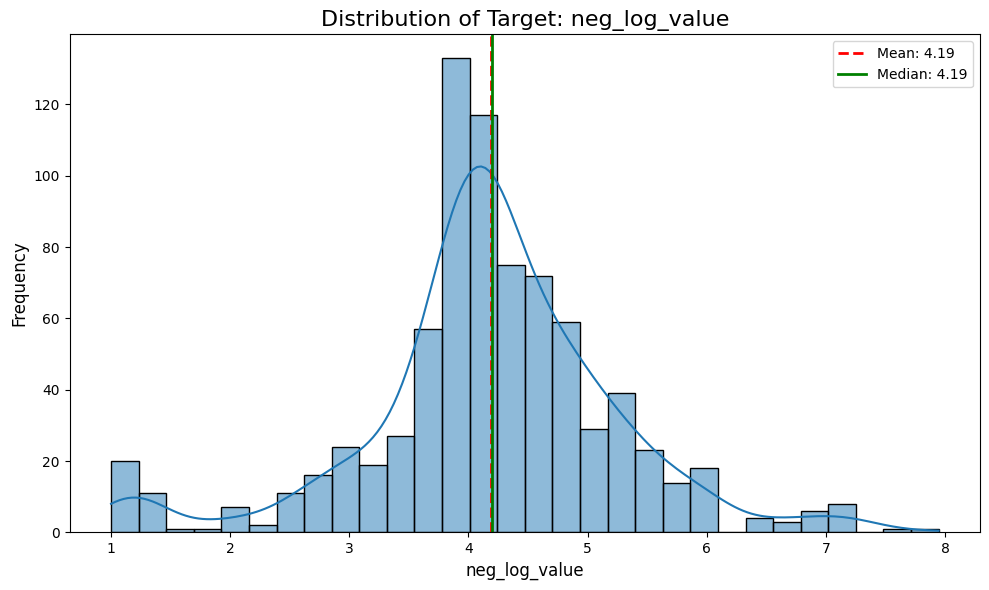

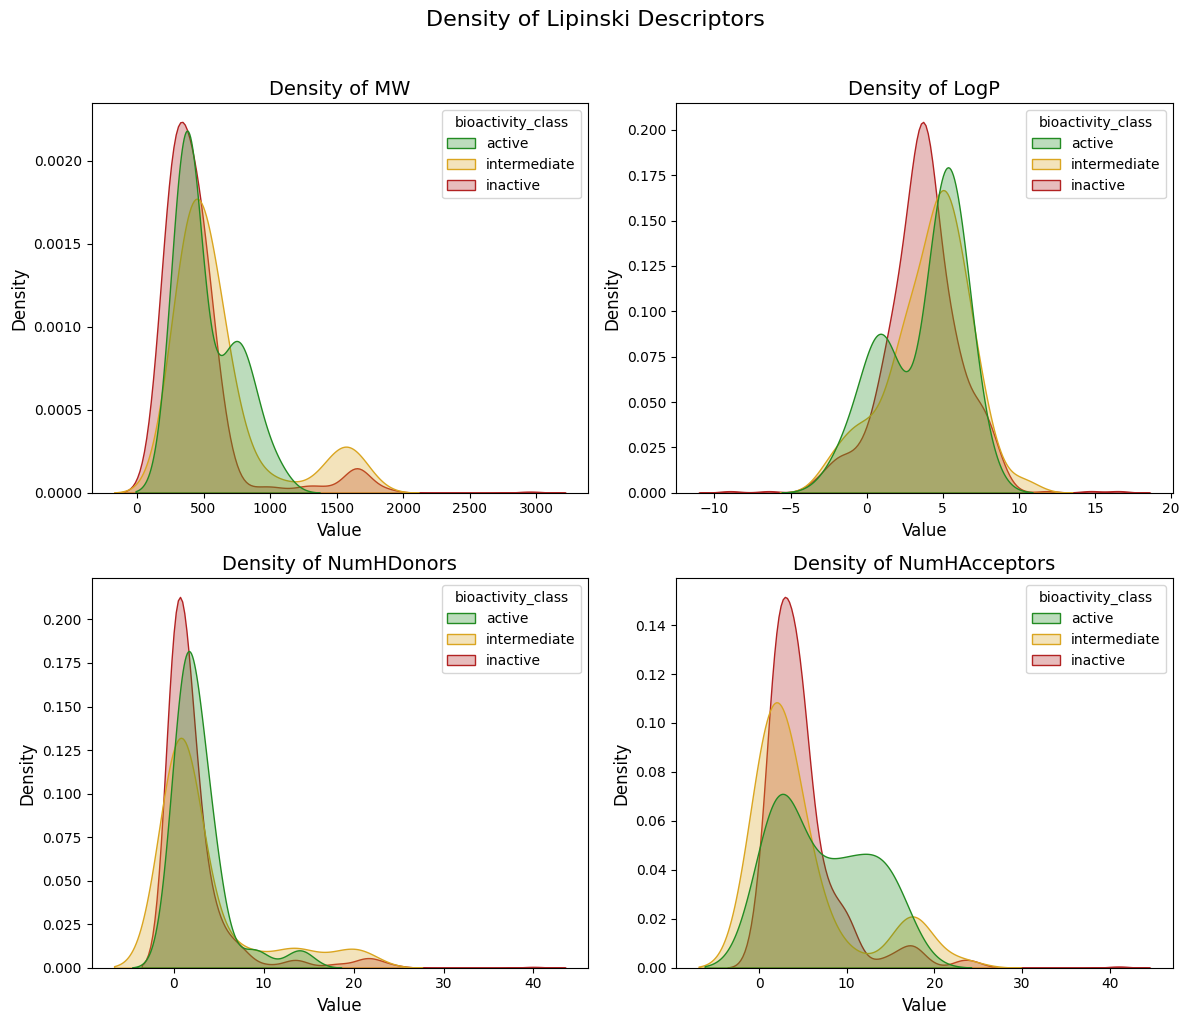

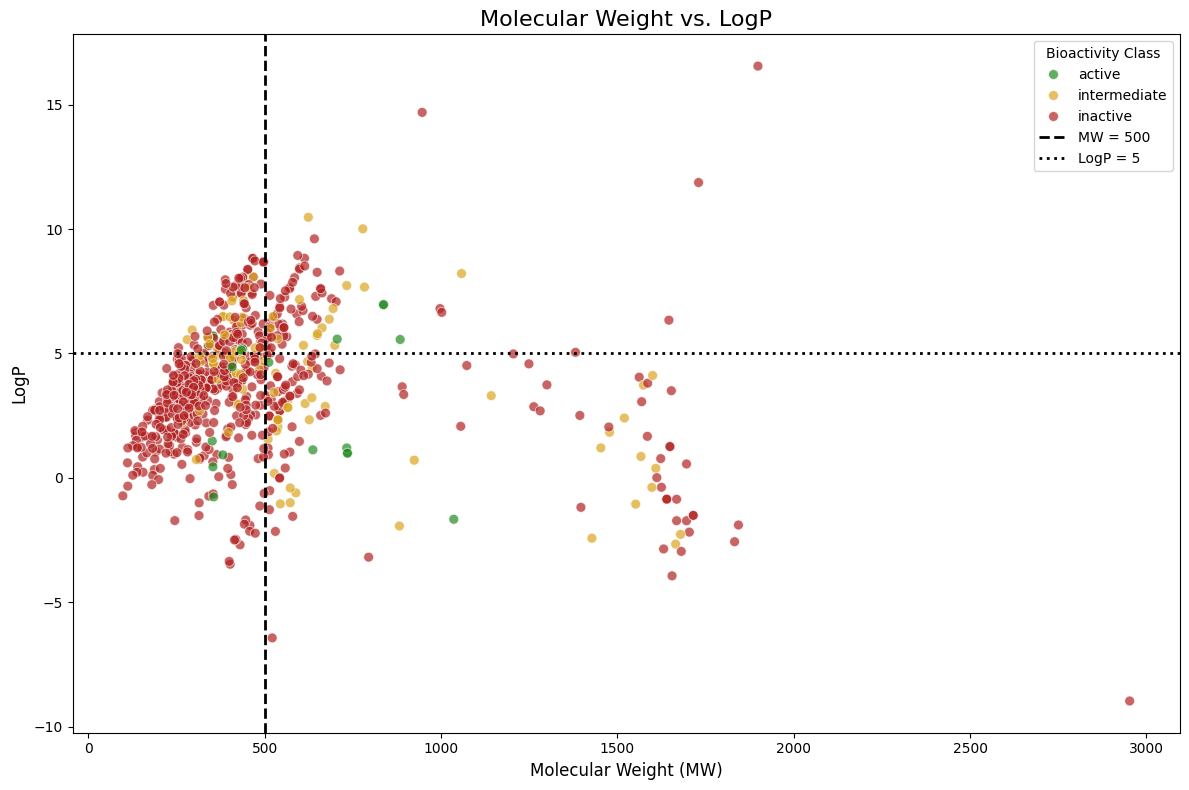

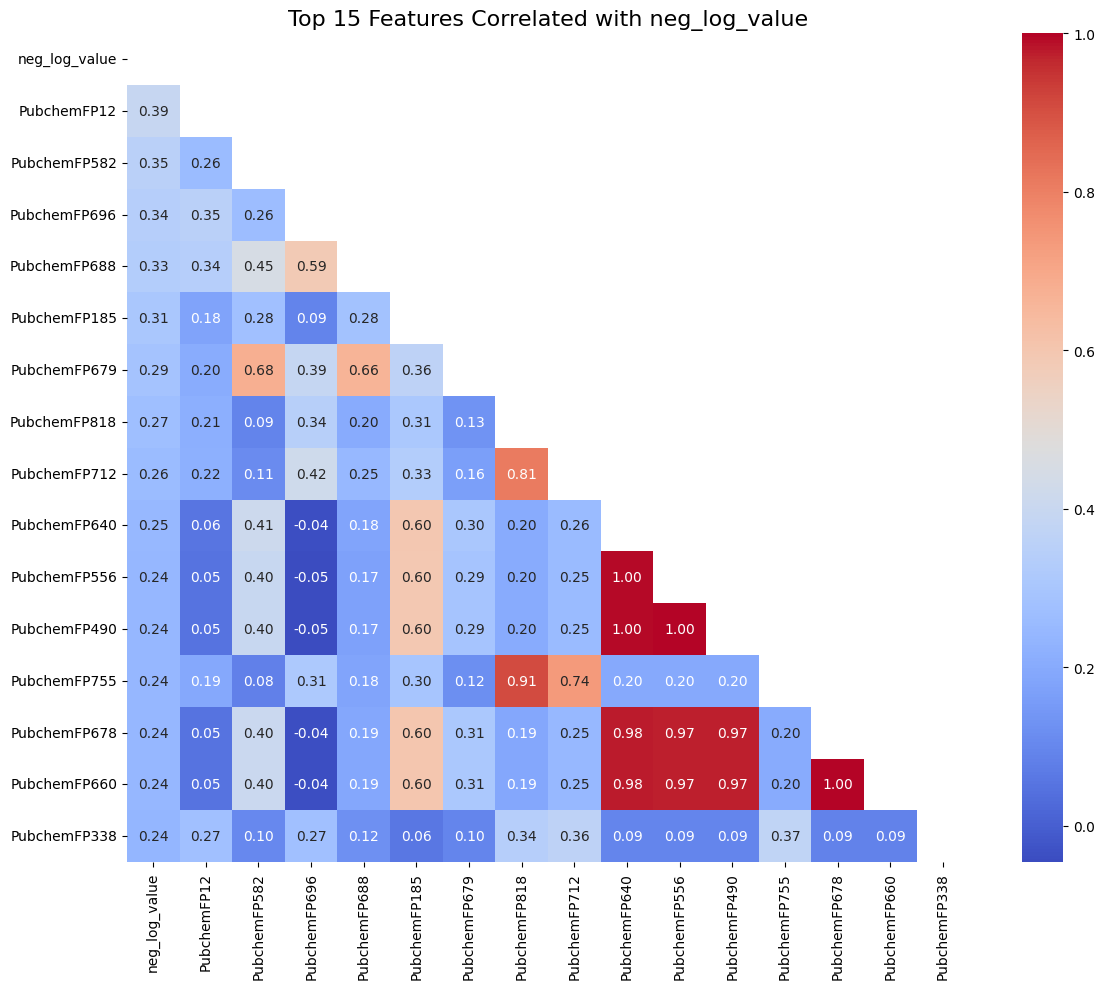

In [3]:
# DataExplorer pode ser utilizado para gerar gráficos de análise exploratória dos dados
explorer = DataExplorer(dataset)
fig1 = explorer.plot_target_distribution()
fig2 = explorer.plot_lipinski_density()
fig3 = explorer.plot_mw_vs_logp()
fig4 = explorer.plot_correlation_heatmap()

In [7]:
# Método setup determina o algoritmo de machine learning, além das
# funções de scoring utilizadas. 
pipeline = ModelPipeline.setup(
        algorithm="xgboost_reg",
        scoring="mae",
        # poderia ser: ["r2","rmse"]
        # ou até: {"mae":make_scorer(mean_absolute_error, greater_is_better=False)}
        )

# Faz a busca de hiperparâmetros por algoritmo genético. Por estar sendo
# utilizado algoritmo pre-definido no pacote, grid de parâmetros já existe.
# Se fosse um estimador externo, param_grid deveria ser fornecido.
# Se fosse multi-métrica, refit deveria ser definido (e.g.: refit = "rmse",)
print(f'Parãmetros antes da otimização:\n{pipeline.params}\n')
param_search = pipeline.optimize_hyperparameters(dataset=dataset, refit='mae')
pd.DataFrame(param_search.cv_results_).to_csv("candida_param_search.csv", index=False)
print(f'Parãmetros depois da otimização:\n{pipeline.params}\n')

# Os parâmetros ótimos já estão definidos em pipeline.params. É possível fornecer
# novos parâmetros pelo argumento params.
cv_results = pipeline.evaluate_model(dataset=dataset)
pd.DataFrame(cv_results).to_csv("candida_cv_results.csv")

# Método unpack_cv_results tira a média e o desvio padrão das métricas para
# facilitar interpretação, e organiza em uma tabela longa
print(pipeline.unpack_cv_results(cv_results))
#   scorer dataset_type      mean        sd
# 0    mae         test -0.456745  0.112118
# 1    mae        train -0.123803  0.008908

# Ajusta o modelo de machine learning e de domínio de aplicabilidade
pipeline.fit(dataset)
pipeline.fit_applicability_domain(dataset)


Setting up MLWrapper object.
Algorithm set to: xgboost_reg
Random state: 42, n_jobs: -1
Optional argument alpha not provided.
Scoring metrics set to: ['mae']
✅ MLWrapper setup complete.
Parãmetros antes da otimização:
{}

Starting hyperparameter optimization with GASearchCV (genetic algorithm parameter search).
CV folds: 3, Population: 30, Generations: 30
Refit: mae. If using multiple metrics, will not provide a final model or best_params . 
Using pre-defined parameter grid for 'xgboost_reg'.
Optional argument crossover_probability not provided.
Optional argument mutation_probability not provided.
Optional argument tournament_size not provided.
Optional argument elitism not provided.
Optional argument keep_top_k not provided.


c:\Users\Administrator\Documents\python_envs\chembl_miner\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Administrator\Documents\python_envs\chembl_miner\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	-338.814	1728.91    	-0.567745  	-9646.72   
1  	60    	-1.80795	6.27072    	-0.526612  	-35.5732   
2  	60    	-0.584029	0.0371021  	-0.526612  	-0.694042  
3  	60    	-0.558029	0.0201556  	-0.526612  	-0.637182  
4  	60    	-0.547057	0.0112389  	-0.526612  	-0.581325  
5  	60    	-0.540728	0.0100145  	-0.525614  	-0.565998  
6  	60    	-0.53556 	0.0097314  	-0.52073   	-0.553896  
7  	60    	-0.527292	0.00836521 	-0.519939  	-0.550292  
8  	60    	-0.524119	0.00590055 	-0.519939  	-0.546844  
9  	60    	-0.52212 	0.00544565 	-0.519939  	-0.549178  
10 	60    	-0.519552	0.00246149 	-0.513702  	-0.525581  
11 	60    	-0.518789	0.00403266 	-0.511624  	-0.529271  
12 	60    	-0.518177	0.006182   	-0.511624  	-0.540824  
13 	60    	-0.515331	0.00370202 	-0.511624  	-0.525034  
14 	60    	-0.514204	0.00576097 	-0.501494  	-0.528071  
15 	60    	-0.511626	0.00517584 	-0.501494  	-0.522619  
16 	60    	-0.510191	0.00622193 	-

c:\Users\Administrator\Documents\python_envs\chembl_miner\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
c:\Users\Administrator\Documents\python_envs\chembl_miner\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: divide by zero encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)


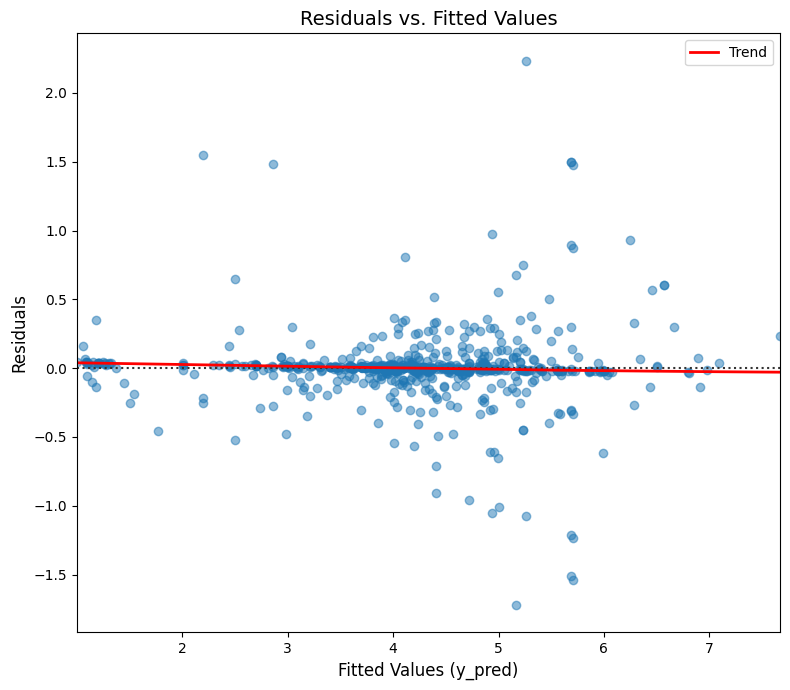

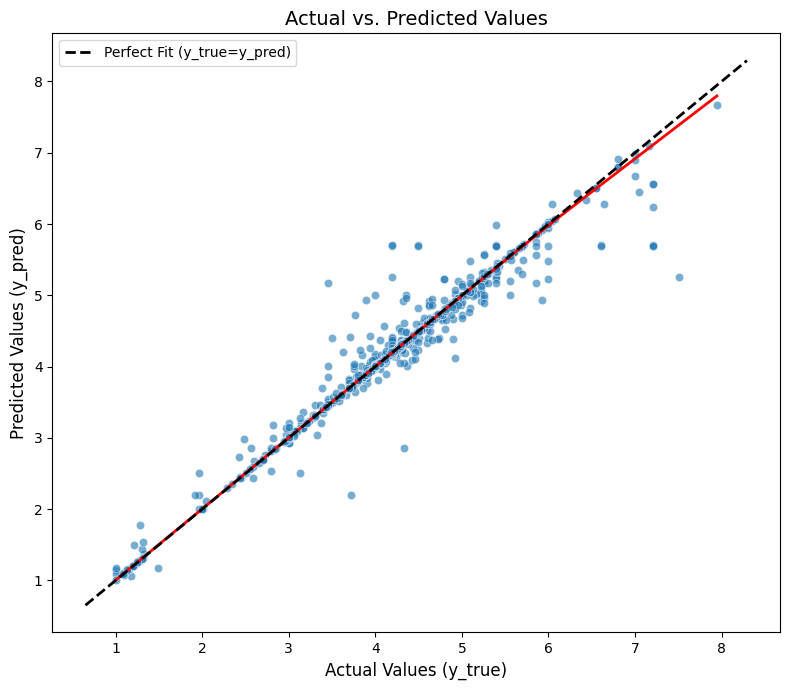

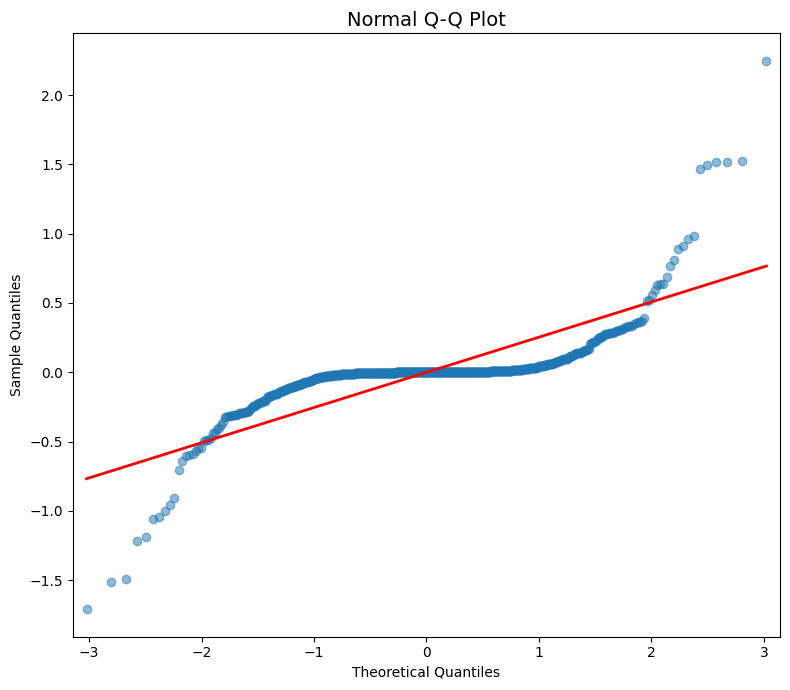

In [8]:
# ModelAnalyzer pode ser utilizado para gerar gráficos de diagnóstico de resíduos
# e (WIP) explicação do modelo
explainer = ModelAnalyzer(pipeline.fit_model, dataset)
fig5 = explainer.plot_residuals_vs_fitted()
fig6 = explainer.plot_actual_vs_predicted()
fig7 = explainer.plot_qq()

In [11]:
# Preparo dos dados para implementação
new_data = pd.read_csv("example_external_data.csv")
new_data = new_data.dropna(subset="canonical_smiles")
new_data_descriptors = calculate_fingerprint(new_data)

# Descritores usados pelo modelo, para alinhamento dos dados
model_features = pipeline.fit_model.feature_names_in_

# Alinha os dados para implementação
pred_data = PredictionData.prepare_dataset(
        deploy_data=new_data,
        deploy_descriptors=new_data_descriptors,
        model_features=model_features,
        )

# Realiza a predição, verificação de domínio de aplicabilidade e presença
# do composto na base de treino. Resultados são armazenados dentro do
# dicionário prediction do objeto PredictionData como um DataFrame
pipeline.deploy(
        deploy_dataset=pred_data,
        training_dataset=dataset,
        )
print(pred_data.prediction['xgboost_reg_1'])
#    predicted_values  in_applicability_domain  is_in_training
# 0          8.123...                     True           False
# 1          7.456...                    False           False

Starting fingerprinters calculation.
This will create temporary files in this folder: descriptors.csv; descriptors.csv.log and molecules.smi
Calculating 'pubchem' fingerprinters.
Total features from fingerprints: 881
Fingerprint calculation complete.
Preparing DeployDatasetWrapper object.
There was a NA in descriptors DataFrame, 2759 rows dropped
Deployment descriptors shape before alignment: (9943, 881)
Deployment descriptors shape after alignment: (9943, 881)
DeployDatasetWrapper object prepared.
Deploying model and making predictions...
Predicting on 9943 samples.
Checking for data leakage from training set...
Assessing applicability domain...
6635 deployment samples are outside the applicability domain.
Predictions added to prediction under key 'xgboost_reg_1'.
✅ Prediction complete.
       predicted_values  in_applicability_domain  is_in_training
0              4.315438                    False           False
1              3.435061                     True           False
2     

In [12]:
# Todos os objetos do pacote podem ser salvos ou carregados usando métodos
# to_path ou from_path.
pipeline.to_path('candida_model_pipeline.pkl')
# pipeline = ModelPipeline.from_path('candida_model_pipeline.pkl')
dataset.to_path('dataset_candida')
# dataset = TrainingData.from_path('dataset_candida')
pred_data.to_path('deploy_data')
# pred_data = PredictionData.from_path('deploy_data')

Saving ModelPipeline object to candida_model_pipeline.pkl.
Pipeline saved successfully.
Saving dataset to dataset_candida folder
Saved general_data to dataset_candida/general_data.csv
Saved x_train to dataset_candida/x_train.csv
Saved x_test to dataset_candida/x_test.csv
Saved y_train to dataset_candida/y_train.csv
Saved y_test to dataset_candida/y_test.csv
Dataset saved to dataset_candida folder
Saving DeploymentDatasetWrapper object to deploy_data.
Creating directory: deploy_data
Creating directory: deploy_data/prediction/
DeploymentDatasetWrapper object with data, descriptors, and predictions saved.
